## Stackoverflow tag recommendation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import re
import warnings; warnings.simplefilter('ignore')
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
import gensim

random_state = 747

## Question Data

Stackoverflow question data downloaded from Google BigQuery and aggregated into a single csv file. 

In [2]:
file = '../../../Data/stackoverflow/questions.csv'
df = pd.read_csv(file, usecols=['title', 'tags'])
df.head(10)

,title,tags
0,Issue with the webpack-bundler,webpack
1,Reducing queries on Firebase,javascript|firebase
2,Passing a Matrix from C++ to MATLAB,c++|matlab|matrix
3,window.onload vs. body.onload vs. document.onr...,javascript
4,How to display two fragments vertically (maste...,android|android-layout|listview|android-fragments
5,How to pass data from servlet to JSP without f...,java|jsp|servlets|jstl
6,collection from customer model is not retrievi...,collections|model|magento2
7,I need to generate and display a random number...,java|android|random
8,Cannot resolve bundle style,python|django|webpack
9,Python run set.intersection with set of sets a...,python-2.7


Data size

In [3]:
df.shape

(16389567, 2)

Data is too big for taining. We will only consider randomly selected 100,000 rows

In [4]:
df = shuffle(df, random_state=random_state)
df = df[:1000000]

### Clean title text

In [5]:
def clean_text(text):
    text = str(text)
    text = re.sub(r"[^a-zA-Z0-9#+-]", " ", text.lower())
    return text

df['title'] = df['title'].apply(clean_text)
df.head(10)

,title,tags
12755393,uiscrollbar is adding a vertical offset when s...,ios|swift|uiscrollview|uiwebview
2587603,how can print value of two columns of a table,asp.net-mvc|asp.net-mvc-2|asp.net-mvc-3|razor
8458851,highcharts time data with irregular intervals ...,javascript|charts|highcharts
704156,should games request audio focus on android,android|audio|android-audiomanager
9586367,wpf buttons don t change when pressed,c#|wpf|xaml
5892363,shrine + dropzone with amazon s3,ruby-on-rails|amazon-s3|coffeescript|dropzone.js
11863530,forcing a digest in angular,angularjs
3752365,npm keeps having issues finding my node path,node.js|npm|nowjs
4442375,expandable list view bottom divider,android|android-layout|android-listview|expand...
139250,unit test fails in xcode 8,ios|objective-c|xcode|xcode8


### Save for later use

In [6]:
df.to_csv('../../../Data/stackoverflow/clean_questions.csv')

### Load data

In [2]:
df = pd.read_csv('../../../Data/stackoverflow/clean_questions.csv')
df.head(10)

,Unnamed: 0,title,tags
0,12755393,uiscrollbar is adding a vertical offset when s...,ios|swift|uiscrollview|uiwebview
1,2587603,how can print value of two columns of a table,asp.net-mvc|asp.net-mvc-2|asp.net-mvc-3|razor
2,8458851,highcharts time data with irregular intervals ...,javascript|charts|highcharts
3,704156,should games request audio focus on android,android|audio|android-audiomanager
4,9586367,wpf buttons don t change when pressed,c#|wpf|xaml
5,5892363,shrine + dropzone with amazon s3,ruby-on-rails|amazon-s3|coffeescript|dropzone.js
6,11863530,forcing a digest in angular,angularjs
7,3752365,npm keeps having issues finding my node path,node.js|npm|nowjs
8,4442375,expandable list view bottom divider,android|android-layout|android-listview|expand...
9,139250,unit test fails in xcode 8,ios|objective-c|xcode|xcode8


In [3]:
df.isnull().sum()

Unnamed: 0    0
title         0
tags          0
dtype: int64

### Save data as list and basic exploration

In [6]:
questions = df['title'].tolist()
tags = df['tags'].tolist()

Find the number of words in the vocabulary

In [7]:
print('The total number of words in the data is: ', sum([len(text.split()) for text in questions]))

def tokenize_question(text):
    return text.split()

question_vect = CountVectorizer(tokenizer=tokenize_question)
question_vect.fit(questions)

print('The number of words in the vocabulary is: ', len(question_vect.vocabulary_))

The total number of words in the data is:  8798904
The number of words in the vocabulary is:  151475


Find the number of tags

In [8]:
def tokenize_tags(text):
    return text.split('|')

tags_vect = CountVectorizer(tokenizer=tokenize_tags)
tags_vect.fit(tags)

print('The total number of tags is: ', len(tags_vect.vocabulary_))

The total number of tags is:  38909


#### Save tag label as vectorized tokens.

There are too many tags to predict. In our model we will only look at the top 100 tags and save the result

In [9]:
max_tags = 100

def tokenize_tags(text):
    return text.split('|')

tags_vect = CountVectorizer(tokenizer=tokenize_tags, max_features=max_tags)
tags = tags_vect.fit_transform(tags)
tags = tags.toarray()
print('Number of tags: ', len(tags_vect.vocabulary_))

tags_token = tags_vect.get_feature_names()
tag_frequency = tags.sum(axis=0)
print('The list of tags with frequency is: ')
print(dict(zip(tags_token, tag_frequency)))

Number of tags:  100
The list of tags with frequency is: 
{'.htaccess': 3873, '.net': 16698, 'ajax': 11743, 'algorithm': 5256, 'amazon-web-services': 3769, 'android': 69219, 'angular': 7932, 'angularjs': 15689, 'apache': 4845, 'api': 3805, 'arrays': 16914, 'asp.net': 20775, 'asp.net-mvc': 10452, 'azure': 3622, 'bash': 6221, 'c': 17322, 'c#': 75600, 'c++': 35400, 'codeigniter': 3783, 'cordova': 3535, 'css': 33322, 'css3': 4693, 'csv': 3539, 'database': 8971, 'django': 10919, 'eclipse': 7023, 'entity-framework': 4789, 'excel': 10683, 'excel-vba': 4954, 'facebook': 5038, 'file': 3604, 'firebase': 3502, 'forms': 5529, 'function': 4203, 'git': 6184, 'google-maps': 3558, 'hibernate': 4458, 'html': 47001, 'html5': 7076, 'image': 5334, 'ios': 35039, 'iphone': 13279, 'java': 88798, 'javascript': 102394, 'jquery': 56638, 'json': 14818, 'laravel': 5815, 'linq': 4277, 'linux': 10227, 'list': 4812, 'loops': 3548, 'macos': 5368, 'matlab': 4887, 'maven': 3755, 'mongodb': 6215, 'multithreading': 6760,

Histogram of number of tags in each question

Text(0,0.5,'Number of questions')

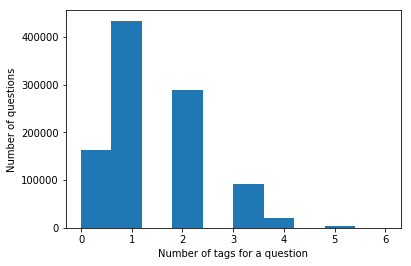

In [10]:
plt.hist(tags.sum(axis=1))
plt.xlabel('Number of tags for a question')
plt.ylabel('Number of questions')

### Split test and train data set

In [11]:
X_train, X_test, y_train, y_test = train_test_split(questions, tags, 
                                                    test_size=0.1, 
                                                    random_state=random_state)

### Sample weight
Evaluate sample weight from y_train data

In [15]:
sample_weight = compute_sample_weight('balanced', y_test)
sample_weight

array([3.24693919e-30, 1.96912514e-27, 8.84745069e-29, ...,
       3.24693919e-30, 1.11515719e-26, 1.82416213e-24])

In [16]:
len(X_train)

900000

### Evaluation metrics

In [12]:
def eval_metrics(y_test, y_predicted, print_metrics=True):
    
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    
    if print_metrics:
        print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (
            accuracy, precision, recall, f1))
    return accuracy, precision, recall, f1

# Simple first order model: Bag of words with logistic regression


### Bag of words embedding for quesitons

Remove common words and words appearing very less number of times from the corpus

In [18]:
def tokenize_question(text):
    return text.split()

bag_vect = CountVectorizer(tokenizer=tokenize_question,
                               stop_words='english',
                               min_df=3,
                               max_df=0.5)

X_train_bag = bag_vect.fit_transform(X_train)
X_test_bag = bag_vect.transform(X_test)
print('The number of words in the vocabulary is: ', len(bag_vect.vocabulary_))

The number of words in the vocabulary is:  37738


### Logistic regression with binary relevance
Since this is a multi-label classificaiton, we will use binary relevance on top of logistical regression. This basically splits each label as a seperate classification. 

In [21]:
%%time
bag_log_clf = OneVsRestClassifier(LogisticRegression())

bag_log_clf.fit(X_train_bag, y_train)

print('Train score')
y_train_bag_predict = bag_log_clf.predict(X_train_bag)
eval_metrics(y_train, y_train_bag_predict)

print('Test score')
y_test_bag_predict = bag_log_clf.predict(X_test_bag)
eval_metrics(y_test, y_test_bag_predict)

KeyboardInterrupt: 

### Important words

In [22]:
importances = importances = bag_log_clf.estimators_[0].coef_[0]
for i in range(1,len(bag_log_clf.estimators_)):
    importances += bag_log_clf.estimators_[i].coef_[0]

importances = importances/sum(importances)
    
feature_imps = {'importances':importances, 'feature':bag_vect.get_feature_names()}
feature_imps = pd.DataFrame(feature_imps)
feature_imps = feature_imps.sort_values('importances', ascending=False)
# Normalize importance and add cumulative importance
feature_imps['cum_imp'] = feature_imps['importances'].cumsum()
feature_imps['importances'] = feature_imps['importances']/feature_imps['importances'].max()
feature_imps = feature_imps.reset_index(drop=True)
feature_imps['no_features'] = feature_imps.index + 1
feature_imps[['feature', 'importances', 'cum_imp']].head(20)

AttributeError: 'OneVsRestClassifier' object has no attribute 'estimators_'

## TFIDF with logistic regression and binary relevance

### TFIDF on bag of words embedding for quesitons

In [ ]:
def tokenize_question(text):
    return text.split()

tfidf_vect = TfidfVectorizer(tokenizer=tokenize_question,
                               stop_words='english',
                               min_df=4,
                               max_df=0.5)

X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)
print('The number of words in the vocabulary is: ', len(tfidf_vect.vocabulary_))

### Logistic regression with binary relevance

In [ ]:
%%time
tfidf_log_clf = OneVsRestClassifier(LogisticRegression())

tfidf_log_clf.fit(X_train_tfidf, y_train)

print('Train score')
y_train_tfidf_predict = tfidf_log_clf.predict(X_train_tfidf)
eval_metrics(y_train, y_train_tfidf_predict)

print('Test score')
y_test_tfidf_predict = tfidf_log_clf.predict(X_test_tfidf)
eval_metrics(y_test, y_test_tfidf_predict)

### Importance words

In [25]:
importances = importances = tfidf_log_clf.estimators_[0].coef_[0]
for i in range(1,len(tfidf_log_clf.estimators_)):
    importances += tfidf_log_clf.estimators_[i].coef_[0]

importances = importances/sum(importances)
    
feature_imps = {'importances':importances, 'feature':tfidf_vect.get_feature_names()}
feature_imps = pd.DataFrame(feature_imps)
feature_imps = feature_imps.sort_values('importances', ascending=False)
# Normalize importance and add cumulative importance
feature_imps['cum_imp'] = feature_imps['importances'].cumsum()
feature_imps['importances'] = feature_imps['importances']/feature_imps['importances'].max()
feature_imps = feature_imps.reset_index(drop=True)
feature_imps['no_features'] = feature_imps.index + 1
feature_imps[['feature', 'importances', 'cum_imp']].head(20)

,feature,importances,cum_imp
0,android,1.000000,0.023515
1,python,0.826409,0.042948
2,jquery,0.799126,0.061739
3,java,0.769738,0.079840
4,php,0.717130,0.096703
5,r,0.641999,0.111800
6,c++,0.626198,0.126525
7,c#,0.602218,0.140686
8,javascript,0.576617,0.154245
9,sql,0.574948,0.167765


## TFIDF with Naives Bayes Classifier and binary relevance

### TFIDF on bag of words embedding for quesitons

In [12]:
def tokenize_question(text):
    return text.split()

tfidf_vect = TfidfVectorizer(tokenizer=tokenize_question,
                               stop_words='english',
                               min_df=4,
                               max_df=0.5)

X_train_tfidf = tfidf_vect.fit_transform(X_train)
X_test_tfidf = tfidf_vect.transform(X_test)
print('The number of words in the vocabulary is: ', len(tfidf_vect.vocabulary_))

The number of words in the vocabulary is:  30308


### Naives Bayes with binary relevance

In [13]:
%%time
tfidf_log_clf = OneVsRestClassifier(GaussianNB())

tfidf_log_clf.fit(X_train_tfidf, y_train)

print('Train score')
y_train_tfidf_predict = tfidf_log_clf.predict(X_train_tfidf)
eval_metrics(y_train, y_train_tfidf_predict)

print('Test score')
y_test_tfidf_predict = tfidf_log_clf.predict(X_test_tfidf)
eval_metrics(y_test, y_test_tfidf_predict)

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

### Importance Words

In [14]:
importances = importances = tfidf_log_clf.estimators_[0].coef_[0]
for i in range(1,len(tfidf_log_clf.estimators_)):
    importances += tfidf_log_clf.estimators_[i].coef_[0]

importances = importances/sum(importances)
    
feature_imps = {'importances':importances, 'feature':tfidf_vect.get_feature_names()}
feature_imps = pd.DataFrame(feature_imps)
feature_imps = feature_imps.sort_values('importances', ascending=False)
# Normalize importance and add cumulative importance
feature_imps['cum_imp'] = feature_imps['importances'].cumsum()
feature_imps['importances'] = feature_imps['importances']/feature_imps['importances'].max()
feature_imps = feature_imps.reset_index(drop=True)
feature_imps['no_features'] = feature_imps.index + 1
feature_imps[['feature', 'importances', 'cum_imp']].head(20)

AttributeError: 'OneVsRestClassifier' object has no attribute 'estimators_'

# Convolutional sentence classification model

## Load Word2Vec

In [5]:
import gensim

word2vec_path = '../../../Data/stackoverflow/GoogleNews-vectors-negative300.bin.gz'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

### Sequence length

Text(0,0.5,'number')

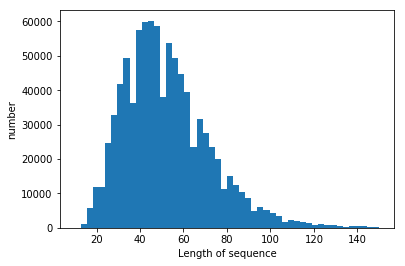

In [16]:
plt.hist([len(x) for x in X_train], bins=50)
plt.xlabel('Length of sequence')
plt.ylabel('number')

### Hyerparameters related to sentece creation

In [102]:
max_seq_length = 35
vocab_size = 100000
embedding_size = 300

### Text preprocessing

In [90]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [111]:
tokenizer = Tokenizer(lower=True, split=' ', filters='')
tokenizer.fit_on_texts(X_train)
tokenizer.num_words = vocab_size

seq_train = tokenizer.texts_to_sequences(X_train)
seq_test = tokenizer.texts_to_sequences(X_test)

max_seq_length = max([len(x) for x in seq_train])

seq_train = pad_sequences(seq_train, maxlen=max_seq_length, padding='post', truncating='post')
seq_test = pad_sequences(seq_test, maxlen=max_seq_length, padding='post', truncating='post')

embedding_weights = np.zeros((vocab_size+1, embedding_size))
word2vec_counter, randword_counter = 0, 0
for word, index in tokenizer.word_index.items():
    if index > vocab_size:
        break
        
    if word in word2vec:
        embedding_weights[index,:] = word2vec[word]
        word2vec_counter += 1
    else:
        embedding_weights[index,:] = np.random.normal(0, 0.15, embedding_size)
        randword_counter += 1
        
print(embedding_weights.shape)

(100001, 300)


In [115]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, concatenate, Dropout
from tensorflow.keras.models import Model

In [124]:
max_seq_length=1000
embedding_layer = Embedding(embedding_weights.shape[0],
                            embedding_weights.shape[1],
                            weights=[embedding_weights],
                            input_length=max_seq_length,
                            trainable=True)

sequence_input = Input(shape=(max_seq_length,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

convs = []
filter_sizes = [3,4,5]


for fsz in filter_sizes:
    l_conv = Conv1D(128,fsz,activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(3)(l_conv)
    convs.append(l_pool)

l_merge = concatenate(convs, axis=1)

l_cov1= Conv1D(64, 3, activation='relu')(l_merge)
l_pool1 = MaxPooling1D(3)(l_cov1)

l_cov2 = Conv1D(32, 3, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(3)(l_cov2)

l_flat = Flatten()(l_pool2)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)


model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("model fitting - simplified convolutional neural network")
model.summary()

model fitting - simplified convolutional neural network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1000, 300)    30000300    input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 998, 128)     115328      embedding_7[0][0]                
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 997, 128)     153728      embedding_7[0][0]                
_____________________________________________________

In [134]:
max_seq_length=35
embedding_layer = Embedding(embedding_weights.shape[0],
                            embedding_weights.shape[1],
                            weights=[embedding_weights],
                            input_length=max_seq_length,
                            trainable=True)

sequence_input = Input(shape=(max_seq_length,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

convs = []
filter_sizes = [3,4,5]


for fsz in filter_sizes:
    l_conv = Conv1D(128,fsz,activation='relu',strides=1)(embedded_sequences)
#     l_pool = MaxPooling1D(3)(l_conv)
    convs.append(l_conv)

l_merge = concatenate(convs, axis=1)

l_cov1= Conv1D(64, 5, activation='relu',strides=2)(l_merge)
# l_pool1 = MaxPooling1D(3)(l_cov1)

l_cov2 = Conv1D(16, 5, activation='relu',strides=2)(l_cov1)
# l_pool2 = MaxPooling1D(3)(l_cov2)

l_flat = Flatten()(l_cov2)
l_dense = Dense(250, activation='relu')(l_flat)
preds = Dense(100, activation='softmax')(l_dense)


model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("model fitting - simplified convolutional neural network")
model.summary()

model fitting - simplified convolutional neural network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 35, 300)      30000300    input_18[0][0]                   
__________________________________________________________________________________________________
conv1d_66 (Conv1D)              (None, 33, 128)      115328      embedding_17[0][0]               
__________________________________________________________________________________________________
conv1d_67 (Conv1D)              (None, 32, 128)      153728      embedding_17[0][0]               
_____________________________________________________